# Buying Round Lots

The *standard mean-variance (Markowitz) portfolio selection model* determines the optimal investments by balancing risk and expected return. In this notebook, we minimize the variance (risk) of the portfolio given that the prescribed level of expected return is attained. Please refer to the [annotated list of references](../literature.rst#portfolio-optimization) for more background information on portfolio optimization.

Securities on the stock market are often traded in *round lots*. A round lot is a fixed number of units (that typically depends on the financial instrument that is traded). For example, stocks are often traded in multiples of 100 shares.  Any smaller quantity of traded securities is called an *odd lot*, which typically induces higher transaction costs, or slower order execution. Also, to avoid small positions, one might want to ensure that a *minimum number of units* is traded if a position is opened.

In this notebook, we add the following constraints to the basic model:

* If a position is opened, it must comprise a minimum number of shares and,
* stocks can only be bought in round lots.

For our example, we will be using a lower bound of 1000 shares per asset and a uniform lot size of 100 shares.

We also include a risk-free asset in the model.

In [1]:
# Install dependencies
%pip install numpy scipy gurobipy pandas matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import gurobipy as gp
import gurobipy_pandas as gppd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Hidden cell to avoid licensing messages
# when docs are generated.
with gp.Model():
    pass

Set parameter WLSAccessID


Set parameter WLSSecret


Set parameter LicenseID to value 2443533


WLS license 2443533 - registered to Gurobi GmbH


## Input Data

The following input data is used within the model:

- $S$: set of stocks
- $p_i$: last price of stock $i$ in USD
- $\mu$: vector of expected returns
- $\Sigma$: PSD variance-covariance matrix
    - $\sigma_{ij}$ covariance between returns of assets $i$ and $j$
    - $\sigma_{ii}$ variance of return of asset $i$

In [4]:
# Import some example data set
Sigma = pd.read_pickle("sigma.pkl")
mu = pd.read_pickle("mu.pkl")

We also import the prices of the assets:

In [5]:
# Import price data
prices = pd.read_pickle("subset_weekly_closings_10yrs.pkl").tail(1).squeeze()
data = pd.DataFrame(data={"Price": prices})

## Formulation
The model minimizes the variance of the portfolio given that the minimum level of expected return is attained. Also
* shares can only be bought in multiples of a lot size $l$, and
* if a position in an asset is bought, it must comprise at least $L$ lots (and hence at least $L\cdot l$ shares).

Mathematically, this results in a convex quadratic mixed-integer optimization problem.

### Model Parameters

We use the following parameters:

- $\bar\mu$: required expected portfolio return
- $\mu_\text{rf}$: risk-free return
- $T$: total investment amount in USD (AUM)
- $L$: minimal number of lots per asset
- $l$: lot size

In [6]:
# Values for the model parameters:
r = 0.25  # Required return
mu_rf = 0.5 / 52  # Risk-free return rate
T = 1e7  # total investment amount
L = 10  # minimal number of lots
l = 100  # lot size

### Decision Variables
We need three types of decision variables:

1. The *proportions* of capital invested among the considered stocks. The corresponding vector of positions is denoted by $x$ with its component $x_i$ denoting the proportion of capital invested in stock $i$.

2. The proportion of capital invested into the risk-free asset is denoted by $x_\text{rf}$.

3. The *number of lots* of shares bought of the considered stocks. The corresponding vector is denoted by $z$ with its component $z_i$ denoting the number of lots in stock $i$. Note that the number of shares in asset $i$ is then $lz_i$.

### Variable Bounds

Each position must be between 0 and 1; this prevents leverage and short-selling:

$$0\leq x_i, x_\text{rf}\leq 1 \; , \;  i \in S$$

The $z_i$ must be integers. To enforce the minimal number $L$ of lots if an asset is bought, we will declare those variables *semi-integer*. That is,

$$z_i \in \mathbb Z\ \text{and}\ z_i=0\ \text{or}\ 0< L \leq z_i \;, \; i \in S$$


We will model this using the [gurobipy-pandas](https://github.com/Gurobi/gurobipy-pandas) package. Using this, we first create an extended DataFrame containing the decision variables.

In [7]:
# Create an empty optimization model
m = gp.Model()

# Add variable: xrf denotes the proportion of risk-free asset
xrf = m.addVar(lb=0, ub=1, name="x_rf")

# Add variables
df_model = (
    # x[i] denotes the proportion invested in stock i
    data.gppd.add_vars(m, name="x", ub=1)
    # z[i] denotes the number of lots of stock i. Must be integer and greater or equal to L or zero.
    # Defining the variable as semi-integer is enough to enforce the buy-in threshold requirement.
    .gppd.add_vars(m, name="z", vtype=gp.GRB.SEMIINT, lb=L)
)

# Inspect the created DataFrame:
m.update()
df_model

Price                     x                     z
APTV   79.150002  <gurobi.Var x[APTV]>  <gurobi.Var z[APTV]>
DVN    44.290001   <gurobi.Var x[DVN]>   <gurobi.Var z[DVN]>
HSY   194.528000   <gurobi.Var x[HSY]>   <gurobi.Var z[HSY]>
CAG    28.020000   <gurobi.Var x[CAG]>   <gurobi.Var z[CAG]>
HST    16.980000   <gurobi.Var x[HST]>   <gurobi.Var z[HST]>
...          ...                   ...                   ...
AEE    76.779999   <gurobi.Var x[AEE]>   <gurobi.Var z[AEE]>
AAPL  187.440002  <gurobi.Var x[AAPL]>  <gurobi.Var z[AAPL]>
AIZ   159.820007   <gurobi.Var x[AIZ]>   <gurobi.Var z[AIZ]>
UNP   215.690002   <gurobi.Var x[UNP]>   <gurobi.Var z[UNP]>
K      52.200001     <gurobi.Var x[K]>     <gurobi.Var z[K]>

[462 rows x 3 columns]

###  Constraints
The budget constraint ensures that the entire capital is invested:

$$\sum_{i \in S} x_i + x_\text{rf} =1 $$

The expected return of the portfolio must be at least $\bar\mu$:

$$\underbrace{\mu_\text{rf} x_\text{rf}}_\text{risk-free return}  + \underbrace{\mu^\top x}_\text{risky return}\geq \bar\mu$$

In [8]:
%%capture
# Budget constraint: all investments sum up to 1
m.addConstr(df_model["x"].sum() + xrf == 1, name="Budget_Constraint")

# Lower bound on expected return
m.addConstr(mu.to_numpy() @ df_model["x"] + mu_rf * xrf >= r, "Minimal_Return")

#### Round lots

The relative position $x_i$ in stock $i$ and the number of round lots $z_i$ are related via the price $p_i$ as follows:

$$
x_i = \frac{l z_i  p_i}{T} \; , \; i \in S
$$

In [9]:
%%capture
gppd.add_constrs(
    m,
    df_model["x"] - l / T * df_model["Price"] * df_model["z"],
    "=",
    0,
    name="match_round_lots",
)

###  Objective Function
The objective is to minimize the risk of the portfolio, which is measured by its variance:

$$\min_x x^\top \Sigma x$$

In [10]:
# Define objective function: Minimize risk
m.setObjective(df_model["x"] @ Sigma.to_numpy() @ df_model["x"], gp.GRB.MINIMIZE)

We now solve the optimization problem:

In [11]:
m.optimize()

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Ubuntu 24.04.1 LTS")


CPU model: AMD EPYC 7763 64-Core Processor, instruction set [SSE2|AVX|AVX2]


Thread count: 1 physical cores, 2 logical processors, using up to 2 threads


WLS license 2443533 - registered to Gurobi GmbH


Optimize a model with 464 rows, 925 columns and 1850 nonzeros


Model fingerprint: 0x5dd8105c


Model has 106953 quadratic objective terms


Variable types: 463 continuous, 0 integer (0 binary)


Semi-Variable types: 0 continuous, 462 integer


Coefficient statistics:


  Matrix range     [9e-05, 1e+00]


  Objective range  [0e+00, 0e+00]


  QObjective range [6e-03, 2e+02]


  Bounds range     [1e+00, 1e+01]


  RHS range        [2e-01, 1e+00]


Presolve time: 0.02s


Presolved: 1388 rows, 1387 columns, 3697 nonzeros


Presolved model has 106953 quadratic objective terms


Variable types: 463 continuous, 924 integer (462 binary)


Found heuristic solution: objective 11.4196528


Root relaxation: objective 1.803654e+00, 161 iterations, 0.01 seconds (0.01 work units)


    Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


     0     0    1.80365    0   62   11.41965    1.80365  84.2%     -    0s


H    0     0                       2.6454205    1.80365  31.8%     -    0s


H    0     0                       2.5624936    1.80365  29.6%     -    0s


     0     0    1.80365    0   62    2.56249    1.80365  29.6%     -    0s


H    0     0                       1.8235545    1.80365  1.09%     -    0s


     0     0    1.80449    0   58    1.82355    1.80449  1.05%     -    0s


     0     0    1.80449    0   58    1.82355    1.80449  1.05%     -    0s


     0     0    1.80449    0   57    1.82355    1.80449  1.05%     -    0s


     0     0    1.80449    0   57    1.82355    1.80449  1.05%     -    0s


     0     0    1.81054    0   53    1.82355    1.81054  0.71%     -    0s


     0     0    1.81054    0   53    1.82355    1.81054  0.71%     -    0s


     0     0    1.81096    0   51    1.82355    1.81096  0.69%     -    0s


     0     0    1.81194    0   48    1.82355    1.81194  0.64%     -    0s


     0     0    1.81734    0   42    1.82355    1.81734  0.34%     -    0s


     0     0    1.81846    0   40    1.82355    1.81846  0.28%     -    0s


     0     0    1.81846    0   40    1.82355    1.81846  0.28%     -    0s


     0     0    1.81846    0   39    1.82355    1.81846  0.28%     -    0s


     0     0    1.81846    0   39    1.82355    1.81846  0.28%     -    0s


     0     0    1.81846    0   39    1.82355    1.81846  0.28%     -    0s


     0     0    1.81846    0   39    1.82355    1.81846  0.28%     -    0s


     0     0    1.81942    0   37    1.82355    1.81942  0.23%     -    0s


     0     0    1.81942    0   37    1.82355    1.81942  0.23%     -    0s


     0     0    1.81950    0   37    1.82355    1.81950  0.22%     -    0s


     0     0    1.81950    0   37    1.82355    1.81950  0.22%     -    0s


H    0     0                       1.8235414    1.81950  0.22%     -    0s


     0     1    1.82035    0   37    1.82354    1.82035  0.17%     -    0s


H   26    13                       1.8235414    1.82193  0.09%   3.6    0s


Cutting planes:


  MIR: 2


  Flow cover: 1


Explored 99 nodes (948 simplex iterations) in 0.80 seconds (0.49 work units)


Thread count was 2 (of 2 available processors)


Solution count 8: 1.82354 1.82355 2.22438 ... 11.4197


Optimal solution found (tolerance 1.00e-04)


Best objective 1.823541386979e+00, best bound 1.823434168542e+00, gap 0.0059%


Display basic solution data:

In [12]:
print(f"Minimum Risk:     {m.ObjVal:.6f}")
print(f"Expected return:  {mu @ df_model['x'].gppd.X:.6f}")
print(f"Solution time:    {m.Runtime:.2f} seconds\n")

# Print investments (with non-negligible value, i.e. >= 1 share)
data["Position"] = pd.concat(
    [df_model["x"].gppd.X, pd.Series([xrf.X], index=["risk-free"])]
)
data["Shares"] = df_model["z"].gppd.X * l

print(f"Number of trades: {data[data['Shares'] >= 1]['Shares'].count()}\n")
print(f"Risk-free alloc:  {xrf.X:.6f}\n")

data[data["Shares"] >= 1].sort_values("Position", ascending=False)[
    ["Position", "Shares", "Price"]
]

Minimum Risk:     1.823541
Expected return:  0.248376
Solution time:    0.81 seconds

Number of trades: 21

Risk-free alloc:  0.168930



Position   Shares       Price
LLY   0.153020   2600.0  588.539978
KDP   0.078814  24800.0   31.780001
PGR   0.075682   4800.0  157.669998
NVDA  0.048888   1000.0  488.880005
DPZ   0.048716   1300.0  374.739990
NOC   0.046388   1000.0  463.880005
ODFL  0.039779   1000.0  397.790009
TMUS  0.039693   2700.0  147.009995
KR    0.035408   8300.0   42.660000
TTWO  0.035282   2300.0  153.399994
WST   0.034423   1000.0  344.230011
WM    0.034234   2000.0  171.169998
ED    0.028055   3100.0   90.500000
MKTX  0.022670   1000.0  226.699997
WMT   0.021846   1400.0  156.039993
CLX   0.021845   1600.0  136.529999
CME   0.021106   1000.0  211.059998
HRL   0.016003   4900.0   32.660000
MNST  0.014326   2600.0   55.099998
XEL   0.008413   1400.0   60.090000
CPB   0.006480   1600.0   40.500000

## Comparison with the unconstrained portfolio

We can also compute and compare the portfolio without the minimum buy-in and lot constraints by changing the variable type and bounds of $z$.

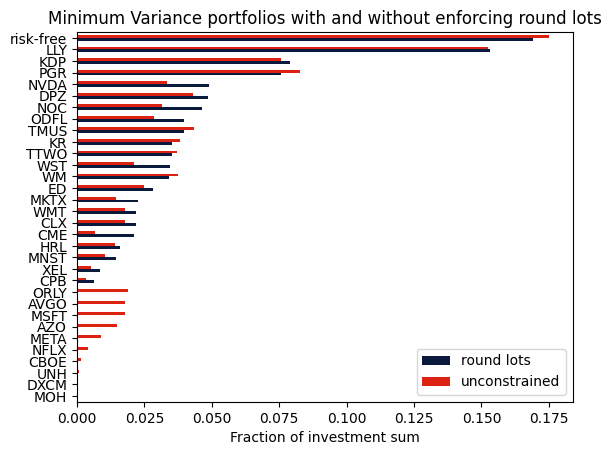

In [13]:
x_lots = pd.concat([data["Position"], pd.Series([xrf.X], index=["risk-free"])])

# change type of z from semi-integer to continuous and lower bound to 0
df_model["z"].gppd.set_attr("vtype", gp.GRB.CONTINUOUS)
df_model["z"].gppd.set_attr("lb", 0)

m.params.OutputFlag = 0
m.optimize()

x_unconstr = pd.concat([df_model["x"].gppd.X, pd.Series([xrf.X], index=["risk-free"])])

# retrieve and display solution data
mask = (x_lots > 1e-5) | (x_unconstr > 1e-5)
df_data = pd.DataFrame(
    index=x_lots[mask].index,
    data={
        "round lots": x_lots[mask],
        "unconstrained": x_unconstr[mask],
    },
).sort_values(by=["round lots", "unconstrained"], ascending=True)

axs = df_data.plot.barh(color=["#0b1a3c", "#dd2113"])
axs.set_xlabel("Fraction of investment sum")
plt.title("Minimum Variance portfolios with and without enforcing round lots")
plt.show()

## Takeaways

* Data from pandas DataFrames can easily be used to build an optimization model via the `gurobipy-pandas` package.
* To enforce buying round lots of shares, one needs to incorporate the asset price and the total investment amount into the model.
* Minimum buy-in and round lot constraints can be modeled using semi-integer variables. Semi-integer variables are integer decision variables that may either take the value 0 or a value between specified bounds. They are a convenient tool to guarantee a minimum position size if an asset is bought.